## Задача

Необходимо выполнить разведывательный анализ реальных данных, чтобы:
- Получить общее представление о датасете
- Проверить возможность использования датасета для экспериментов с многорукими бандитами. В частности предложить формальную постановку задачи бандитов с использованием датасета
- Или, как минимум, наметить следующий шаг для постановки задачи

### Постановка задачи многруких бандитов

Реальный датасет может быть полезен для табличного определения задачи многрукого бандита (формально это состязательная установка), для чего необходимо:
- Определить общий список действий
- Определить раунды и награды для каждого действия на каждом раунде

### Данные

Используются данные https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop

Данные являются логом событий пользователей - просмотр товара, добавление товара в корзину, покупка товара, удаление товара из корзины.

Для применения к данным алгоритмов многоруких бандитов фактически требуется перевести лог событий в табличный формат наград на каждом раунде.

### Гипотезы для проверки

Простейший способ использовать данные для эксперимента с многорукими бандитами - найти одного пользователя, лог событий которого можно преобразовать в табличную форму наград за действия на каждом раунде.

Первичные предположительные требования к пользователю:
- событий достаточно много (не менее 100)
- есть события покупки, и их не мало (не менее 10% от всех событий, желательно, не менее 100)
- события можно ассоциировать с небольшим числом действий (например, товары, или товарные категории)

## Метод исследования

- Получить общее представление о датасете
- Рассчитать статистики пользователей
- Попытаться найти пользователей, удовлетворяющих требованию
- Сформулировать выводы, включая дальнешие пути и возможные альтернативные постановки задачи многоруких бандитов (например, использовать данные не одного пользователя)

In [2]:
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

DATA_PATH = '../../data/cosmetics_ecommerce_events'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #last_expr

#### Столбцы и их типы
Тут и далее будут использоваться только данные за Октябрь 2019 (всего доступны данные за 5 месяцев)

In [9]:
df_oct = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')
f'Oct data shape: {df_oct.shape}'
df_oct.columns
df_oct.dtypes
df_oct.describe()
df_oct.info()
df_oct.head(10)

'Oct data shape: (4102283, 9)'

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

product_id   category_id         price       user_id
count  4.102283e+06  4.102283e+06  4.102283e+06  4.102283e+06
mean   5.468464e+06  1.545652e+18  8.534920e+00  5.013416e+08
std    1.321863e+06  1.563666e+17  1.913315e+01  8.171257e+07
min    3.752000e+03  1.487580e+18 -7.937000e+01  4.103071e+06
25%    5.723489e+06  1.487580e+18  2.140000e+00  4.692921e+08
50%    5.809115e+06  1.487580e+18  4.110000e+00  5.389695e+08
75%    5.850322e+06  1.487580e+18  7.140000e+00  5.575029e+08
max    5.900470e+06  2.195085e+18  3.076000e+02  5.662808e+08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03 UTC       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07 UTC       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07 UTC       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15 UTC       cart     5881449  1487580013522845895   
5  2019-10-01 00:00:16 UTC       cart     5857269  1487580005134238553   
6  2019-10-01 00:00:19 UTC       cart     5739055  1487580008246412266   
7  2019-10-01 00:00:24 UTC       cart     5825598  1487580009445982239   
8  2019-10-01 00:00:25 UTC       cart     5698989  1487580006317032337   
9  2019-10-01 00:00:26 UTC       view     5875317  2029082628195353599   

  category_code   brand  price    user_id  \
0           NaN  runail   2.62  463240011   
1           NaN  runail   2.62  463240011   
2           NaN  lovely  13.48  429681830   
3           NaN  runail   2.62  463240011   
4           NaN  lovely   0.56  429681830   
5           NaN  runail   2.62  430174032   
6           NaN  kapous   4.75  377667011   
7           NaN     NaN   0.56  467916806   
8           NaN     NaN   1.27  385985999   
9           NaN     NaN   1.59  474232307   

                           user_session  
0  26dd6e6e-4dac-4778-8d2c-92e149dab885  
1  26dd6e6e-4dac-4778-8d2c-92e149dab885  
2  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
3  26dd6e6e-4dac-4778-8d2c-92e149dab885  
4  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
5  73dea1e7-664e-43f4-8b30-d32b9d5af04f  
6  81326ac6-daa4-4f0a-b488-fd0956a78733  
7  2f5b5546-b8cb-9ee7-7ecd-84276f8ef486  
8  d30965e8-1101-44ab-b45d-cc1bb9fae694  
9  445f2b74-5e4c-427e-b7fa-6e0a28b156fe

### Рассмотрим категории товаров

Категории являются хорошим кандидатом, чтобы ассоциировать с ними действия в задаче многоруких бандитов.

Начнем с кода категорий (```category_code```)

In [87]:
# Category code
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_category_code = df['category_code'].notna().sum()
events_with_category_code

f'events with category code fraction {events_with_category_code / df.shape[0]:.4f}'

df['category_code'].value_counts()

(4102283, 9)

67477

'events with category code fraction 0.0164'

appliances.environment.vacuum             27732
stationery.cartrige                       13459
apparel.glove                              7430
furniture.living_room.cabinet              6234
accessories.bag                            5848
furniture.bathroom.bath                    5018
appliances.personal.hair_cutter             828
accessories.cosmetic_bag                    642
appliances.environment.air_conditioner      161
furniture.living_room.chair                 123
sport.diving                                  2
Name: category_code, dtype: int64

**Лишь 1.6 процента событий содержат код категорий, это поле не удастся использовать.**

Рассмотрим теперь ```category_id```.

(4102283, 9)

4102283

'events with category fraction 1.0'

490

<BarContainer object of 490 artists>

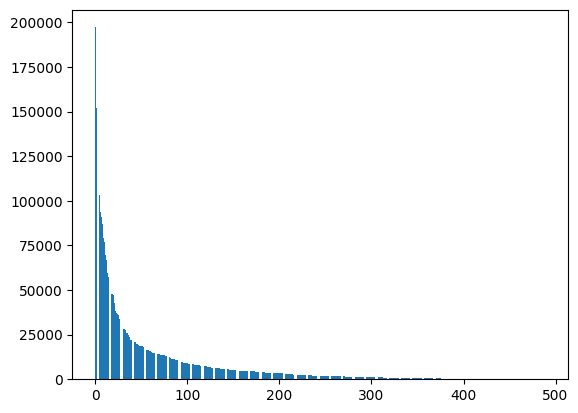

In [88]:
# Category id
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_category = df['category_id'].notna().sum()
events_with_category

f'events with category fraction {events_with_category / df.shape[0]}'

df['category_id'].nunique()

# сколько событий у категории номер x (категории упорядочены по числу событий)
value_counts = df['category_id'].value_counts().reset_index(drop=True)

plt.bar(value_counts.index, value_counts)


**Все события имеют идентификатор категории, всего 490 категорий. Категории можно использовать, чтобы ассоциировать с ними действия в задаче многоруких бандитов.**

### Рассмотрим бренды

Бренды (столбец ```brand```) также являются хорошим кандидатом, чтобы ассоциировать с ними действия в задаче многоруких бандитов.

(4102283, 9)

2443022

'events with brand fraction 0.596'

runail       306239
irisk        226589
masura       195170
grattol      132130
bpw.style    114192
              ...  
gena              2
dessata           2
shifei            1
ikoo              1
pueen             1
Name: brand, Length: 240, dtype: int64

240

<BarContainer object of 240 artists>

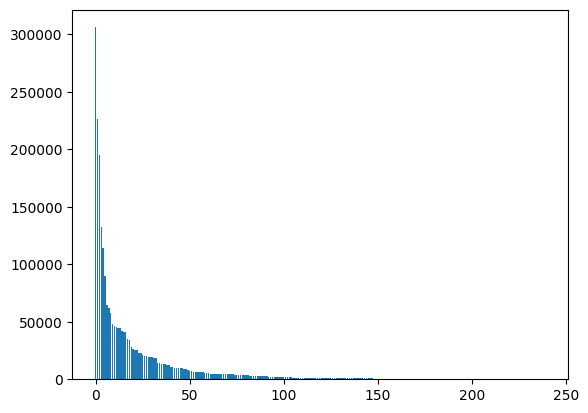

In [104]:
# Brand
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_brand = df['brand'].notna().sum()
events_with_brand

f'events with brand fraction {events_with_brand / df.shape[0]:.3f}'

df['brand'].value_counts()

df['brand'].nunique()

# сколько событий у бренда номер x (бренды упорядочены по числу событий)
value_counts = df['brand'].value_counts().reset_index(drop=True)

plt.bar(value_counts.index, value_counts)

**Около 60% событий имеют бренд, всего 240 брендов. Бренды можно использовать, чтобы ассоциировать с ними действия в задаче многоруких бандитов, но придется пожертвовать примерно половиной данных.**

### Рассмотрим столбцы время и типы события

Эти столбцы являются обязательными для постановки задачи многоруких бандитов.

(4102283, 9)

4102283

'events with event_time fraction 1.0'

4102283

'events with event_type fraction 1.0'

4

<BarContainer object of 4 artists>

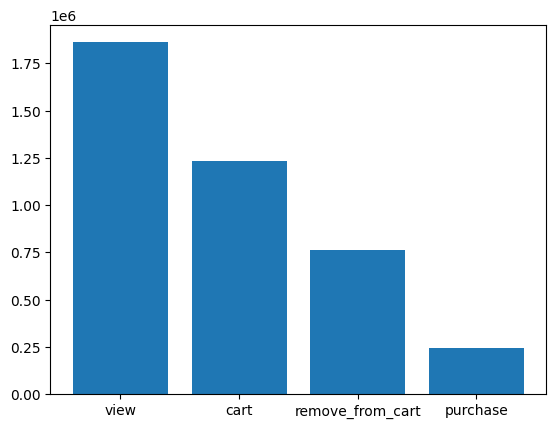

In [90]:
# Event type, event time
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_event_time = df['event_time'].notna().sum()
events_with_event_time

f'events with event_time fraction {events_with_event_time / df.shape[0]}'

events_with_event_type = df['event_type'].notna().sum()
events_with_event_type

f'events with event_type fraction {events_with_event_type / df.shape[0]}'

df['event_type'].nunique()

value_counts = df['event_type'].value_counts()

plt.bar(value_counts.index, value_counts)


Значения типа и времени события проставлены для всех строк в датасете.

Можно также отметить немалое количесво событий удаления товаров из корзины.

### Рассмотрим столбцы идентификатора пользователя и сессии

Эти столбцы являются обязательными для постановки задачи многоруких бандитов.

In [91]:
# user_id, user_session
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_user_id = df['user_id'].notna().sum()
f'events with user_id fraction {events_with_user_id / df.shape[0]:.3f}'

events_with_user_session = df['user_session'].notna().sum()
f'events with user_session fraction {events_with_user_session / df.shape[0]:.3f}'

(4102283, 9)

'events with user_id fraction 1.000'

'events with user_session fraction 1.000'

Значения идентификатора пользователя и сесии проставлены для всех строк в датасете.

### Рассмотрим идентификаторы товаров

Товары являются хорошим кандидатом, чтобы ассоциировать с ними действия в задаче многоруких бандитов.

(4102283, 9)

'events with product_id fraction 1.000'

41899

<BarContainer object of 100 artists>

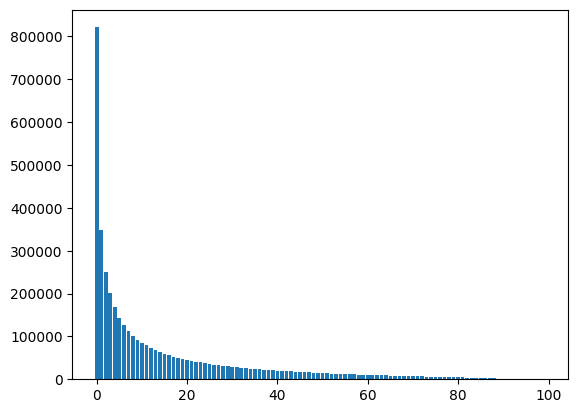

In [92]:
# product_id
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df.shape

events_with_product_id = df['product_id'].notna().sum()
f'events with product_id fraction {events_with_product_id / df.shape[0]:.3f}'

df['product_id'].nunique()

value_counts = df['product_id'].value_counts().reset_index(drop=True)

# сколько событий у группы продуктов номер x 
#(группы получены объединением в "корзины" соседних упорядоченных по числу событий продуктов)
# удобно, чтобы не визуализировать 41899 баров
res = value_counts.groupby(pd.cut(value_counts.index, 100)).sum().reset_index(drop=True)

plt.bar(res.index, res)

Идентификаторы товаров проставлены для всех событий. Товаров почти на 2 порядка больше, чем категорий и брендов.

### Рассмотрим пользователей и их события

Рассмотрим количество событий каждого пользователя.

Простой способ - построить график в осях (количество событий пользователя) х (количество пользователей с таким числом событий). Недостатком будет являться разреженность одной части графика и высокая плотность другой части. Вместо количества событий по оси X предлагается отложить ранг количества событий пользователя.

Предлагается построить два графика - для всех событий и для событий покупки.

(399664,)

167268

Series([], Name: event_type, dtype: int64)

<BarContainer object of 748 artists>

(25762,)

2619

<BarContainer object of 128 artists>

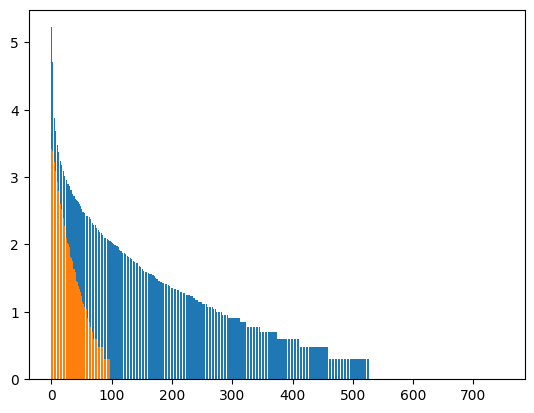

In [93]:
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

events_count_per_user = df.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

value_counts = events_count_per_user.value_counts().reset_index(drop=True)

# сколько пользователей имеют самое распространенное число событий (1, вероятно)
max(value_counts)

events_count_per_user[events_count_per_user >= 100000]

# log сколько пользователей имеет номер x числа событий 
# (номер назначен по порядку возрастания количеств событий у одного пользователя)
plt.bar(value_counts.index, np.log10(value_counts))
# plt.show()

purchase_events = df[df['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()
purchase_events_count_per_user.shape

value_counts = purchase_events_count_per_user.value_counts().reset_index(drop=True)

# сколько пользователей имеют самое распространенное число покупок (1, вероятно)
max(value_counts)

# log сколько пользователей имеет номер x числа событий покупки
plt.bar(value_counts.index, np.log10(value_counts))

**Можно отметить, что события покупки есть лишь у 25 тысяч пользователей из почти 400 тысяч.**

Кроме графика с рангами следует рассмотреть "обычное" распределение числа событий покупок по пользователям. Сколько пользователей имеют X событий покупки ("обычный" вариант оранжевого "рангового" графика выше).

Приводится два графика в логарифмических и обычных осях.

(25762,)

<AxesSubplot:>

<BarContainer object of 128 artists>

<AxesSubplot:>

<BarContainer object of 128 artists>

(87,)

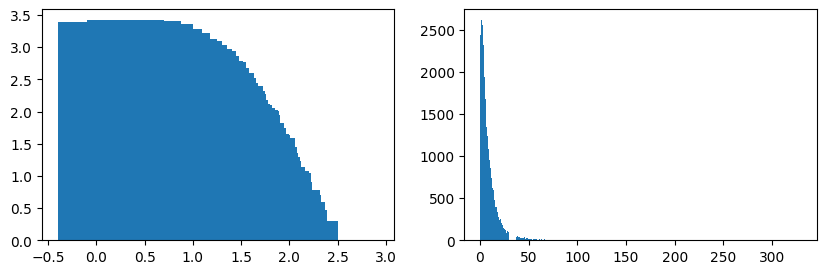

In [94]:
# Отдельно события покупки

df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

purchase_events = df[df['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()
purchase_events_count_per_user.shape

value_counts = purchase_events_count_per_user.value_counts()

fig = plt.figure(figsize=(10,3))
plt.subplot(121)
# log сколько пользователей имеет log x событий покупки
plt.bar(np.log10(value_counts.index), np.log10(value_counts))

plt.subplot(122)
# сколько пользователей имеет x событий покупки
plt.bar(value_counts.index, value_counts)

purchase_events_count_per_user[purchase_events_count_per_user >= 80].shape

Можно отметить:
- **Очень малое количество пользователей с числом покупок больше ~25**
- "Вырезанные" значения в диапазоне около 25

### Поиск подходящих пользователей

Пользователи, которые представляют интерес согласно постановке исследования должны:
- Иметь много событий вообще
- Среди них немало событий покупки

Предлагается визуализировать всех пользователей на графике типа scatter в осях (log10(количество событий) x (доля событий-покупок).

Для наглядности один из графиков использует прозрачные маркеры.

(25762,)

(399664,)

(399664, 2)

<AxesSubplot:>

<AxesSubplot:>

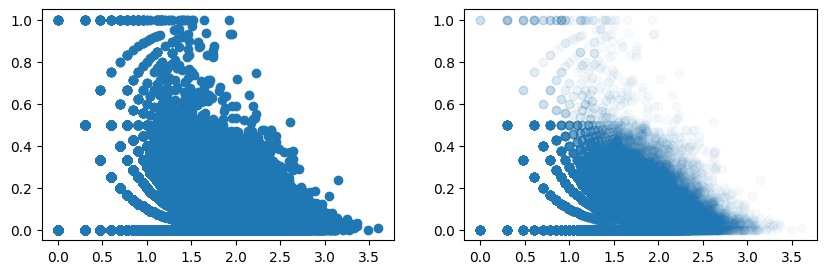

In [95]:
# Число событий у пользователя и доля событий покупок среди них

df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

purchase_events = df[df['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()\
    .rename('purchase_events_count')
purchase_events_count_per_user.shape

events_count_per_user = df.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

events_count_per_user_df = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

res = events_count_per_user_df.merge(purchase_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)

res.shape

fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.scatter(np.log10(res['events_count']), res['purchase_events_count']/res['events_count'])

plt.subplot(122)
plt.scatter(np.log10(res['events_count']), res['purchase_events_count']/res['events_count'], alpha=0.03)


Можно отметить:
- **Необычную частично симметричную круговую структуру данных**
- Локализацию основной массы пользователей

Интересно вручную просмотреть лог действий пользователей:
- с долей событий покупок = 1
- с долей событий покупок = 0
- среди симметричной части фигуры
- среди области локализации основной массы пользователей

Найдем таких пользователей, случайно выберем из доступных

In [96]:
# События конкретных пользователей
np.random.seed(1)

df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

purchase_events = df[df['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()\
    .rename('purchase_events_count')
purchase_events_count_per_user.shape

events_count_per_user = df.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

events_count_per_user_df = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

res = events_count_per_user_df.merge(purchase_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)
res['purchase_fraction'] =  res['purchase_events_count']/res['events_count']
res['log10_events_count'] = np.log10(res['events_count'])

res1 = res[(res['purchase_fraction'] < 0.51) & (res['purchase_fraction'] > 0.49) 
           & (res['log10_events_count'] < 0.8) & (res['log10_events_count'] > 0.5)]
res1.shape
res1_selected = res1.iloc[np.random.choice(res1.shape[0], 5, replace=False)]
res1_selected

res2 = res[(res['log10_events_count'] < 2) & (res['log10_events_count'] > 1.5) 
           & (res['purchase_fraction'] == 1)]
res2.shape
res2_selected = res2.iloc[np.random.choice(res2.shape[0], 3, replace=False)]
res2_selected

res3 = res[(res['log10_events_count'] < 2.5) & (res['log10_events_count'] > 2) 
           & (res['purchase_fraction'] == 0)]
res3.shape
res3_selected = res3.iloc[np.random.choice(res3.shape[0], 3, replace=False)]
res3_selected

res4 = res[(res['purchase_fraction'] < 0.3) & (res['purchase_fraction'] > 0.1) 
           & (res['log10_events_count'] < 2.5) & (res['log10_events_count'] > 2)]
res4.shape
res4_selected = res4.iloc[np.random.choice(res4.shape[0], 10, replace=False)]
res4_selected

(25762,)

(399664,)

(219, 4)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
560922453             4                    2.0                0.5   
428430792             4                    2.0                0.5   
429654025             4                    2.0                0.5   
563764298             6                    3.0                0.5   
560558953             4                    2.0                0.5   

           log10_events_count  
user_id                        
560922453            0.602060  
428430792            0.602060  
429654025            0.602060  
563764298            0.778151  
560558953            0.602060

(4, 4)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
559254396            85                   85.0                1.0   
539527508            32                   32.0                1.0   
479525864            44                   44.0                1.0   

           log10_events_count  
user_id                        
559254396            1.929419  
539527508            1.505150  
479525864            1.643453

(2348, 4)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
380375096           126                    0.0                0.0   
542855820           104                    0.0                0.0   
537129753           130                    0.0                0.0   

           log10_events_count  
user_id                        
380375096            2.100371  
542855820            2.017033  
537129753            2.113943

(1981, 4)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
340189216           292                   34.0           0.116438   
555056152           105                   14.0           0.133333   
248736997           130                   21.0           0.161538   
233280499           177                   25.0           0.141243   
538332136           164                   21.0           0.128049   
558123306           120                   14.0           0.116667   
474673837           248                   35.0           0.141129   
461256140           221                   43.0           0.194570   
497541551           112                   17.0           0.151786   
471160138           114                   17.0           0.149123   

           log10_events_count  
user_id                        
340189216            2.465383  
555056152            2.021189  
248736997            2.113943  
233280499            2.247973  
538332136            2.214844  
558123306            2.079181  
474673837            2.394452  
461256140            2.344392  
497541551            2.049218  
471160138            2.056905

In [97]:
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

df_sel_col = df[['user_id', 'user_session', 'event_time', 'product_id', 'event_type', 'price']]


#### Рассмотрим пользователя с идентификатором 558123306

Он имеет долю событий покупок 11%, всего 120 событий.

In [110]:
# Пользователь с долей событий покупок 11%, всего 120 событий
user_id = 558123306
user_events = df_sel_col[df_sel_col['user_id'] == user_id]
user_events['event_time'] = pd.to_datetime(user_events['event_time'])

pd.set_option('display.max_rows', len(user_events))
user_events = user_events.sort_values(by=['event_time'])
user_events
pd.reset_option('display.max_rows')

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


user_id                          user_session  \
1157418  558123306  90126b34-298d-4e6c-b6ac-b394721b3070   
1157489  558123306  90126b34-298d-4e6c-b6ac-b394721b3070   
1158716  558123306  90126b34-298d-4e6c-b6ac-b394721b3070   
1159138  558123306  90126b34-298d-4e6c-b6ac-b394721b3070   
1159439  558123306  90126b34-298d-4e6c-b6ac-b394721b3070   
1218603  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1224455  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1224532  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1224806  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226507  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226527  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226570  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226601  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226700  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226773  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226797  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1226831  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227045  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227159  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227246  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227323  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227361  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1227423  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228056  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228088  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228092  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228120  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228139  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228160  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228157  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228170  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228224  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228274  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228295  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228313  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228314  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228344  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228405  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228408  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228584  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228603  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1228927  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229023  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229037  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229035  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229074  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229101  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229156  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229208  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229209  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1229937  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1244929  558123306  c63b2a0a-f62e-4a7f-9253-734ab6736c19   
1360525  558123306  afd3efb5-bd4a-4c51-bc76-24503f9b1445   
1360539  558123306  afd3efb5-bd4a-4c51-bc76-24503f9b1445   
1360580  558123306  4d0872fd-bd69-4535-8fba-f8615dd1777c   
1360592  558123306  4d0872fd-bd69-4535-8fba-f8615dd1777c   
1360641  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360652  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360677  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360676  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360680  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360684  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360708  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360873  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360883  558123306  bba3342d-6385-47f9-89e2-b8022187ccc5   
1360893  558123306  bba3342d-6385-47f9-89e2-b802218

Можно отметить:
- События просмотра, добавления в корзину, покупки зачастую следуют "пакетами" (с покупкой это можно объяснить разовым оформлением заказа)
- Одни и те же товары могут быть просмотрены подряд многократно
- В корзину может быть добавлен товаров, который не был просмотрен вообще, или оказывается просмотрен после добавления
- Из корзины может быть удален товар больше раз, чем добавлен

Часть особенностей может объясняться ограниченность фрагмента данных, но, в общем случае, следует ожидать, что события могут быть перемешаны как угодно.

In [99]:
# выводы и по другим пользователям

### Разнообразие товаров у пользователей

Если ассоциировать с действиями просмотр определенных товаров, то немаловажно, можно ли найти пользователя, который просматривает и покупает относительно небольшое число товаров.

Это можно формализовать в виде статистики пользователя "разнообразие" (```diversity```) - отношение числа уникальных товаров в событиях пользователя или в событиях покупках пользователя к общему числу событий или событий покупок соответственно.

<AxesSubplot:>

(array([6.00000e+00, 5.00000e+00, 2.00000e+01, 6.00000e+01, 2.34000e+02,
        9.06000e+02, 3.19800e+03, 6.63720e+04, 6.41950e+04, 2.64668e+05]),
 array([-2.20411998, -1.98370798, -1.76329599, -1.54288399, -1.32247199,
        -1.10205999, -0.88164799, -0.66123599, -0.440824  , -0.220412  ,
         0.        ]),
 <BarContainer object of 10 artists>)

<AxesSubplot:>

(array([6.0000e+00, 4.0000e+00, 2.1000e+01, 6.0000e+01, 2.3300e+02,
        9.0700e+02, 3.1970e+03, 6.6317e+04, 6.0912e+04, 4.9796e+04]),
 array([-2.20411998e+00, -1.98389586e+00, -1.76367173e+00, -1.54344760e+00,
        -1.32322347e+00, -1.10299935e+00, -8.82775219e-01, -6.62551092e-01,
        -4.42326965e-01, -2.22102837e-01, -1.87871013e-03]),
 <BarContainer object of 10 artists>)

<AxesSubplot:>

(array([1.1000e+01, 3.0000e+00, 2.1900e+02, 1.1100e+02, 1.3300e+02,
        7.2000e+01, 1.0400e+02, 2.2700e+02, 2.8800e+02, 2.4594e+04]),
 array([0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 10 artists>)

<AxesSubplot:>

(array([ 11.,   3., 219.,  86.,  81., 146., 107., 224., 268., 394.]),
 array([0.33333333, 0.3993921 , 0.46545086, 0.53150963, 0.59756839,
        0.66362715, 0.72968592, 0.79574468, 0.86180344, 0.92786221,
        0.99392097]),
 <BarContainer object of 10 artists>)

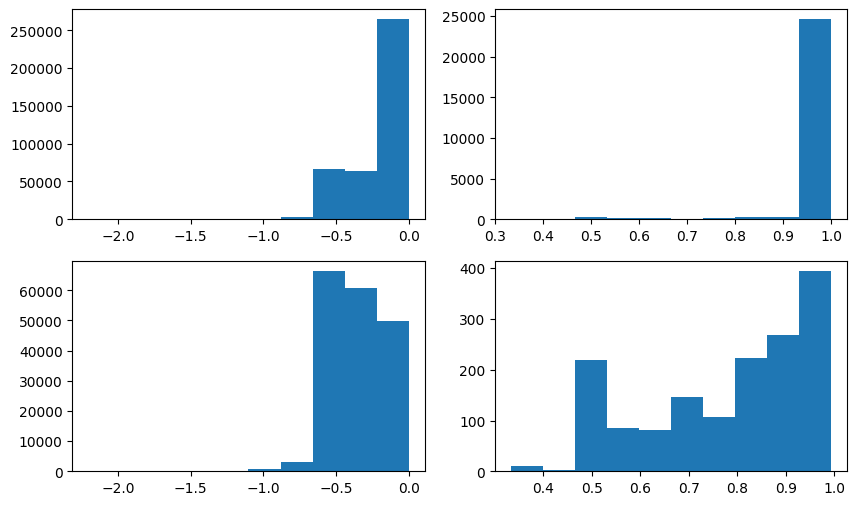

In [100]:
# Разнообразие товаров по пользователям и разнообразие товаров по пользователям среди событий покупок
# И с фильтром разнообразие < 1
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

res = df.groupby(['user_id'])['product_id'].agg(['nunique', 'count'])
res['diversity'] = res['nunique'] / res['count']

fig = plt.figure(figsize=(10,6))
plt.subplot(221)
plt.hist(np.log10(res['diversity']))

res_cut = res[res['diversity'] < 1]
plt.subplot(223)
plt.hist(np.log10(res_cut['diversity']))

purchase_events = df[df['event_type'] == 'purchase']
res = purchase_events.groupby(['user_id'])['product_id'].agg(['nunique', 'count'])
res['diversity'] = res['nunique'] / res['count']

plt.subplot(222)
plt.hist(res['diversity'])

res_cut = res[res['diversity'] < 1]
plt.subplot(224)
plt.hist(res_cut['diversity'])


На графиках показаны гистограммы log10(diversity) и diversity для всех данных и для подмножества с diversity < 1.

**Можно отметить, что пользователей с diversity < 1, что соответствует повторению продуктов в логах событий пользователей, крайне мало**

#### Объединение статистик пользователей

Рассчитаем для каждого пользователя:
- число событий и log10 число событий
- число событий покупок и их долю
- число товаров, уникальных товаров и diversity по всем событиям
- аналогично по событиям покупкам (оставим nan для пользователей без покупок)

In [101]:
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

purchase_events = df[df['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()\
    .rename('purchase_events_count')
purchase_events_count_per_user.shape

events_count_per_user = df.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

events_count_per_user_df = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

res = events_count_per_user_df.merge(purchase_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)
res.shape

res['purchase_fraction'] =  res['purchase_events_count']/res['events_count']
res['log10_events_count'] = np.log10(res['events_count'])

user_products_stat = df.groupby(['user_id'])['product_id'].agg(['nunique', 'count'])
user_products_stat['product_diversity'] = user_products_stat['nunique'] / user_products_stat['count']
user_products_stat = user_products_stat.rename(columns={'nunique': 'product_nunique', 'count': 'product_count'})
user_products_stat.shape

purchase_user_products_stat = purchase_events.groupby(['user_id'])['product_id'].agg(['nunique', 'count'])
purchase_user_products_stat['purchased_product_diversity'] = purchase_user_products_stat['nunique'] / purchase_user_products_stat['count']
purchase_user_products_stat = purchase_user_products_stat\
    .rename(columns={'nunique': 'purchased_product_nunique', 'count': 'purchased_product_count'})
purchase_user_products_stat.shape

res2 = user_products_stat.merge(purchase_user_products_stat, how='left', left_index=True, right_index=True)#.fillna(0)
res2.shape

user_stats = res.merge(res2, how='inner', left_index=True, right_index=True)
user_stats.shape

user_stats[~user_stats['purchased_product_diversity'].isna()]

(25762,)

(399664,)

(399664, 2)

(399664, 3)

(25762, 3)

(399664, 6)

(399664, 10)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
29025780             52                   18.0           0.346154   
31229488             53                    4.0           0.075472   
33535391             45                   11.0           0.244444   
33609704             53                    9.0           0.169811   
34080306             42                    3.0           0.071429   
...                 ...                    ...                ...   
566264460            36                    6.0           0.166667   
566270279            48                    6.0           0.125000   
566270544             3                    1.0           0.333333   
566272734            21                    7.0           0.333333   
566274213             6                    1.0           0.166667   

           log10_events_count  product_nunique  product_count  \
user_id                                                         
29025780             1.716003               22             52   
31229488             1.724276               21             53   
33535391             1.653213               18             45   
33609704             1.724276               26             53   
34080306             1.623249               21             42   
...                       ...              ...            ...   
566264460            1.556303               18             36   
566270279            1.681241               18             48   
566270544            0.477121                1              3   
566272734            1.322219                9             21   
566274213            0.778151                1              6   

           product_diversity  purchased_product_nunique  \
user_id                                                   
29025780            0.423077                       18.0   
31229488            0.396226                        4.0   
33535391            0.400000                       10.0   
33609704            0.490566                        9.0   
34080306            0.500000                        3.0   
...                      ...                        ...   
566264460           0.500000                        6.0   
566270279           0.375000                        6.0   
566270544           0.333333                        1.0   
566272734           0.428571                        7.0   
566274213           0.166667                        1.0   

           purchased_product_count  purchased_product_diversity  
user_id                                                          
29025780                      18.0                     1.000000  
31229488                       4.0                     1.000000  
33535391                      11.0                     0.909091  
33609704                       9.0                     1.000000  
34080306                       3.0                     1.000000  
...                            ...                          ...  
566264460                      6.0                     1.000000  
566270279                      6.0                     1.000000  
566270544                      1.0                     1.000000  
566272734                      7.0                     1.000000  
566274213                      1.0                     1.000000  

[25762 rows x 10 columns]

Теперь можно попытаться найти пользователей с критериям на основе рассчитанных статистик

In [102]:
# можно ли найти пользователя с большим числом событий, немалой долей покупок и низким разнообразием

predicate = (user_stats['product_diversity'] < 0.5)\
  & (user_stats['purchase_events_count'] > 100)\
  & (user_stats['purchase_fraction'] > 0.1)
len(user_stats[predicate])

user_stats[predicate]

24

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
243184747           405                  150.0           0.370370   
433401909           352                  130.0           0.369318   
462431850           276                  111.0           0.402174   
480463194           419                  152.0           0.362768   
489129331           436                  146.0           0.334862   
499085268           511                  147.0           0.287671   
517859679           936                  114.0           0.121795   
520220043           548                  111.0           0.202555   
522798083           309                  119.0           0.385113   
539691934          1118                  178.0           0.159213   
542422154           626                  105.0           0.167732   
546345937           411                  123.0           0.299270   
546827800          1394                  329.0           0.236011   
547020118           284                  119.0           0.419014   
549195612           445                  131.0           0.294382   
551154243           437                  125.0           0.286041   
552249068           651                  110.0           0.168971   
553861723           677                  122.0           0.180207   
556935814           902                  107.0           0.118625   
557850743           807                  104.0           0.128872   
559265331           773                  141.0           0.182406   
560168040           284                  127.0           0.447183   
562421519           170                  127.0           0.747059   
563301515           427                  159.0           0.372365   

           log10_events_count  product_nunique  product_count  \
user_id                                                         
243184747            2.607455              189            405   
433401909            2.546543              145            352   
462431850            2.440909              132            276   
480463194            2.622214              179            419   
489129331            2.639486              185            436   
499085268            2.708421              224            511   
517859679            2.971276              246            936   
520220043            2.738781              153            548   
522798083            2.489958              149            309   
539691934            3.048442              508           1118   
542422154            2.796574              249            626   
546345937            2.613842              119            411   
546827800            3.144263              372           1394   
547020118            2.453318              140            284   
549195612            2.648360              179            445   
551154243            2.640481              205            437   
552249068            2.813581              292            651   
553861723            2.830589              192            677   
556935814            2.955207              262            902   
557850743            2.906874              244            807   
559265331            2.888179              354            773   
560168040            2.453318              130            284   
562421519            2.230449               51            170   
563301515            2.630428              198            427   

           product_diversity  purchased_product_nunique  \
user_id                                                   
243184747           0.466667                      149.0   
433401909           0.411932                      130.0   
462431850           0.478261                      111.0   
480463194           0.427208                      152.0   
489129331           0.424312                      125.0   
499085268           0.438356                      136.0   
517859679           0.262821                       71

In [103]:
user_id = 557850743
user_events = df_sel_col[df_sel_col['user_id'] == user_id]
user_events['event_time'] = pd.to_datetime(user_events['event_time'])

pd.set_option('display.max_rows', len(user_events))
user_events = user_events.sort_values(by=['event_time'])
user_events
pd.reset_option('display.max_rows')

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


user_id                          user_session  \
1124679  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1125241  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1125390  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1300774  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1300914  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1300924  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1300931  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1300964  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1301130  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1301342  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1301405  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1301485  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1301770  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325120  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325793  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325796  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325811  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325819  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1325998  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326009  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326012  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326148  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326150  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326199  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326205  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1326820  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327139  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327178  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327217  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327221  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327239  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327244  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327252  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327321  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327328  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1327364  557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
1543039  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551245  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551441  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551440  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551539  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551691  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551704  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551851  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1551865  557850743  ac708bd1-7b61-442a-98b6-6b0eeef71b02   
1556629  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1556780  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1557096  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1568122  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1568144  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1568145  557850743  aaff5dfc-bb31-458a-8d8b-32ad400688fc   
1575007  557850743  d2bec378-2d8b-42c9-9e41-812bfd3faff9   
1751598  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1751689  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1751690  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1751698  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1751700  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1751952  557850743  4fdaa1b7-f798-4f83-9f80-3ae3ff6fec0c   
1752058  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752512  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752513  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752515  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752517  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752521  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752519  557850743  a071a2a9-91b5-4634-b4ea-c8ed81912a35   
1752526  557850743  a071a2a9-91b5-4634-b4ea-c8ed819

## Выводы

По сформулированным изначально критериям подходящих пользователей крайне мало от общего числа (примерно десятки от сотен тысяч). 

Причем пригодность данных одного пользователя для экспериментов с многорукими бандитами по-прежнему под вопросом. Возможные проблемы:
- мало событий, мало раундов
- большое разнообразие товаров, большое общее число действий
- мало результативных событий (которые можно связать с наградой)

Что делать дальше:
- Пробовать превратить лог найденных пользователей в таблицу наград

Варианты:
- Рассмотреть варианты объединения данных нескольких пользователей
- Рассмотреть помещение в корзину и даже просмотр тоже как положительный результат (с наградой), то есть рассмотреть разные варианты постановки задачи
- Задействовать категории и бренды при определении действий - их гораздо меньше, чем товаров

В далекой перспективе:
- Как-то задействовать сессии
- Учесть price в размере награды
